Installing and Importing Necessary Libraries

In [1]:
import torch
import numpy as np
import os
import json

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Data Importing from Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Preprocessed Data Loading

In [4]:
def load_json(json_path):
  with open(json_path, 'r') as f:
    return json.load(f)

# classes = load_json('/content/drive/MyDrive/Sign-Language-Translator/data_isl_cslrt/sentence_class_names.json')
classes = load_json('/content/drive/MyDrive/Sign-Language-Translator/data_include/Include_class_names.json')

num_classes = len(classes)
print("Number of classes:", num_classes)

Number of classes: 262


In [5]:
class_to_label = {class_name: i for i, class_name in enumerate(classes)}
label_to_class = {i: class_name for i, class_name in enumerate(classes)}

In [6]:
from torch.utils.data import Dataset, DataLoader

In [7]:
def load_saved_data(data_path, train=False):
  if not os.path.exists(data_path):
    return []

  data_type = 'train' if train else 'test'
  features, labels = torch.load(data_path)[data_type]
  return list(zip(features, labels))

In [8]:
# data_path = '/content/drive/MyDrive/Sign-Language-Translator/data_isl_cslrt/preprocessed_video_ISL_CSLRT_data.pth'
data_path = '/content/drive/MyDrive/Sign-Language-Translator/data_include/preprocessed_video_INCLUDE_data.pth'
data = load_saved_data(data_path)
# data[0][0].shape, data[0][1]

In [9]:
class HandGestureDataset(Dataset):
    def __init__(self, saved_data_path='', train=False):
        self.cache = dict(enumerate(load_saved_data(saved_data_path, train)))

    def __len__(self):
        return len(self.cache)

    def __getitem__(self, idx):
        cached_data = self.cache[idx]
        features, label = cached_data[0], class_to_label[cached_data[1]]
        features = features.to(dtype=torch.float32)

        return features, label

def video_collate_fn(batch):
  batch = list(filter(lambda x: x[0] is not None, batch))

  videos, labels = zip(*batch)
  max_size = max(video.shape[0] for video in videos)

  padded_videos = []
  for video in videos:
    pad_size = max_size - video.shape[0]
    pad_tensor = torch.zeros((pad_size, *video.shape[1:]))
    padded_videos.append(torch.cat([pad_tensor, video], dim=0))

  return torch.stack(padded_videos), torch.tensor(labels)

In [10]:
train_dataset = HandGestureDataset(saved_data_path=data_path, train=True)
val_dataset = HandGestureDataset(saved_data_path=data_path)

In [11]:
len(train_dataset), len(val_dataset)

(6407, 851)

In [12]:
train_dataset[6][0].shape, train_dataset[6][1]

(torch.Size([8, 67, 3]), 78)

In [13]:
import pandas as pd

# Aggregate features across all samples and time steps
all_features = []
for i in range(len(train_dataset)):
    all_features.extend(train_dataset[i][0].tolist())

all_features = torch.tensor(all_features).reshape(-1,201)
df = pd.DataFrame(all_features.numpy())
df.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0,0.615644,2.088421,-0.754646,0.530570,2.163676,-0.767597,0.519152,2.296209,-0.780450,0.543642,...,-0.902514,-0.458188,2.508443,-1.061989,0.328056,1.642163,3.117421,-0.182855,1.652192,3.023037
1,0.346929,0.451416,-2.274137,0.399343,0.435545,-2.371367,0.385524,0.476613,-2.494416,0.345946,...,-2.329250,-0.436504,2.479018,-1.336526,0.370447,1.690656,2.048494,-0.140406,1.733617,1.814644
2,0.175766,-0.017961,-1.899764,0.036181,-0.111667,-1.887592,-0.026937,-0.208098,-1.899637,-0.074592,...,-1.877625,-0.422017,2.477868,-0.711295,0.371106,1.707852,0.801004,-0.138789,1.779458,0.532891
3,0.110040,0.043334,-2.155181,0.003405,-0.044260,-2.159797,-0.054348,-0.124244,-2.183157,-0.102795,...,-2.176793,-0.483701,2.530208,-0.830631,0.368046,1.747515,1.318249,-0.162469,1.809879,1.059924
4,0.145275,0.122503,-2.474364,0.039008,0.044568,-2.478128,-0.018470,-0.045762,-2.501235,-0.067810,...,-2.540993,-0.528664,2.645140,-0.609187,0.383112,1.863613,0.909137,-0.182561,1.922988,0.679606


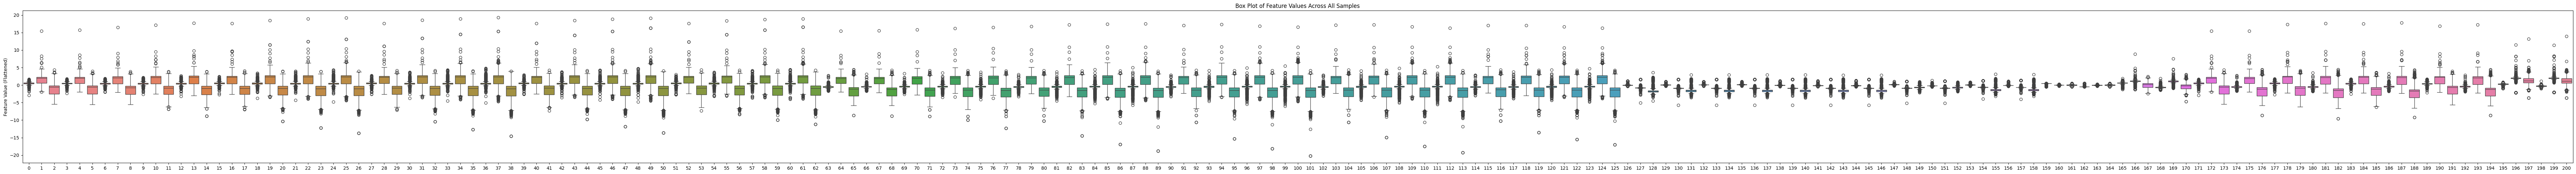

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a box plot of the aggregated features
plt.figure(figsize=(100, 6))
sns.boxplot(df)
plt.title('Box Plot of Feature Values Across All Samples')
plt.ylabel('Feature Value (Flattened)')
plt.show()

In [15]:
# Create DataLoaders for the training and testing datasets
# Set num_workers to 0 to avoid CUDA re-initialization issues with multiprocessing
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=video_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=video_collate_fn)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(val_dataset)}")

Training dataset size: 6407
Testing dataset size: 851


In [16]:
for x_batch, y_batch in train_dataloader:
  print("Features data shape:", x_batch.shape, "Label:", y_batch.shape)
  # break

Features data shape: torch.Size([32, 17, 67, 3]) Label: torch.Size([32])
Features data shape: torch.Size([32, 17, 67, 3]) Label: torch.Size([32])
Features data shape: torch.Size([32, 16, 67, 3]) Label: torch.Size([32])
Features data shape: torch.Size([32, 16, 67, 3]) Label: torch.Size([32])
Features data shape: torch.Size([32, 18, 67, 3]) Label: torch.Size([32])
Features data shape: torch.Size([32, 25, 67, 3]) Label: torch.Size([32])
Features data shape: torch.Size([32, 19, 67, 3]) Label: torch.Size([32])
Features data shape: torch.Size([32, 22, 67, 3]) Label: torch.Size([32])
Features data shape: torch.Size([32, 23, 67, 3]) Label: torch.Size([32])
Features data shape: torch.Size([32, 25, 67, 3]) Label: torch.Size([32])
Features data shape: torch.Size([32, 18, 67, 3]) Label: torch.Size([32])
Features data shape: torch.Size([32, 15, 67, 3]) Label: torch.Size([32])
Features data shape: torch.Size([32, 20, 67, 3]) Label: torch.Size([32])
Features data shape: torch.Size([32, 17, 67, 3]) La

In [17]:
for x_batch, y_batch in val_dataloader:
  print("Features data shape:", x_batch.shape, "Label:", y_batch.shape)
  # break

Features data shape: torch.Size([32, 20, 67, 3]) Label: torch.Size([32])
Features data shape: torch.Size([32, 20, 67, 3]) Label: torch.Size([32])
Features data shape: torch.Size([32, 19, 67, 3]) Label: torch.Size([32])
Features data shape: torch.Size([32, 20, 67, 3]) Label: torch.Size([32])
Features data shape: torch.Size([32, 21, 67, 3]) Label: torch.Size([32])
Features data shape: torch.Size([32, 18, 67, 3]) Label: torch.Size([32])
Features data shape: torch.Size([32, 23, 67, 3]) Label: torch.Size([32])
Features data shape: torch.Size([32, 22, 67, 3]) Label: torch.Size([32])
Features data shape: torch.Size([32, 23, 67, 3]) Label: torch.Size([32])
Features data shape: torch.Size([32, 20, 67, 3]) Label: torch.Size([32])
Features data shape: torch.Size([32, 21, 67, 3]) Label: torch.Size([32])
Features data shape: torch.Size([32, 22, 67, 3]) Label: torch.Size([32])
Features data shape: torch.Size([32, 17, 67, 3]) Label: torch.Size([32])
Features data shape: torch.Size([32, 23, 67, 3]) La

Model Building and Training

In [18]:
from torch import nn
# from torch_geometric_temporal.nn import STConv

In [19]:
# ----- Frame Encoder -----
class FrameEncoder(nn.Module):
    def __init__(self, in_frame_size, hidden_neurons, dropout_rates, frame_dim, frame_fc_dropout):
        """
        in_frame_size: features per node (e.g. x,y,z,conf → 4)
        hidden_neurons: list of hidden layer sizes [64, 128, ...]
        frame_dim: output embedding dimension for each frame
        dropout_rates: list of dropouts per layer (same length as hidden_neurons)
        frame_fc_dropout: dropout for the fully-connected layer
        """
        super().__init__()
        layers = []
        input_dim = in_frame_size

        if dropout_rates is None:
            dropout_rates = [0.0] * len(hidden_neurons)

        # Feature Projections per node
        for h, dr in zip(hidden_neurons, dropout_rates):
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dr))
            input_dim = h

        self.node_proj = nn.Sequential(*layers)

        # Frame fully-connected projection
        self.frame_fc = nn.Sequential(
            nn.Linear(input_dim, frame_dim),
            nn.ReLU(),
            nn.Dropout(frame_fc_dropout)  # global dropout
        )

    def forward(self, x):
        # x: (B, T, N*F) -> flatten nodes per frame
        x = x.reshape(x.shape[0], x.shape[1], -1)  # (B,T,N*F)

        x = self.node_proj(x)          # (B,T,H_last)
        # x, _ = self.attention(x, x, x) # (B,T,H_last)
        x = self.frame_fc(x)           # (B,T,frame_dim)
        return x

# ----- Sequence Classifier -----
class SequenceClassifier(nn.Module):
    def __init__(self, in_frame_dim, temporal_size, num_temporal_layers, numHeads, temporal_dropout,
                 class_hidden_neurons, class_dropout_rates, output_size, rnn_type="TRANSFORMER"):
        """
        in_frame_dim: per-frame embedding dimension
        temporal_size: hidden size of temporal encoder
        num_temporal_layers: how many GRU/LSTM layers
        temporal_dropout: dropout for the temporal encoder
        class_hidden_neurons: list of hidden layer sizes for the classifier
        class_droput_rates: list of dropouts per layer (same length as class_hidden_neurons)
        """
        super().__init__()
        self.use_transformer = rnn_type == "TRANSFORMER"

        if rnn_type == "GRU":
            self.rnn = nn.GRU(in_frame_dim, temporal_size,
                              num_layers=num_temporal_layers,
                              bidirectional=True, batch_first=True,
                              dropout=temporal_dropout if num_temporal_layers > 1 else 0.0)

        elif rnn_type == "TRANSFORMER":
            self.rnn = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model=in_frame_dim, nhead=numHeads, dropout=temporal_dropout, batch_first=True),
                num_layers=num_temporal_layers
            )

        fc_input_size = temporal_size if self.use_transformer else 2 * temporal_size

        # temporal pooling + classifier
        self.temp_pool = nn.AdaptiveAvgPool2d((1, fc_input_size))  # (B, 1, fc_input)

        layers = []
        input_dim = fc_input_size

        for h, dr in zip(class_hidden_neurons, class_dropout_rates):
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dr))
            input_dim = h

        layers.append(nn.Linear(input_dim, output_size))

        self.classifier = nn.Sequential(*layers)

    def forward(self, x):
        # x: (B, T, D)
        if self.use_transformer:
            seq_out = self.rnn(x)                   # (B,T,2*H)
        else:
            seq_out, _ = self.rnn(x)                # (B,T,2*H)

        # seq_out = seq_out.transpose(1, 2)       # (B,2*H,T)
        pooled = self.temp_pool(seq_out).squeeze(-2)  # (B,2*H)
        out = self.classifier(pooled)
        return out


# ----- Combined Model -----
class MyModel(nn.Module):
    def __init__(self, in_frame_size, frame_proj_neurons, proj_dropout_rates, frame_fc_dropout,
                 frame_dim, temporal_size, num_temporal_layers, numHeads, temporal_dropout,
                 class_hidden_neurons, class_dropout_rates, output_size, rnn_type="GRU"):
        super().__init__()
        self.frame_encoder = FrameEncoder(in_frame_size, frame_proj_neurons, proj_dropout_rates,
                                          frame_dim, frame_fc_dropout)

        self.sequence_classifier = SequenceClassifier(frame_dim, temporal_size, num_temporal_layers, numHeads, temporal_dropout,
                                                      class_hidden_neurons, class_dropout_rates, output_size, rnn_type=rnn_type)

    def forward(self, x):
        # x: (B,T,F) where F = N*features
        frame_emb = self.frame_encoder(x)   # (B,T,frame_dim)
        out = self.sequence_classifier(frame_emb)  # (B,num_classes)
        return out


In [20]:
x = torch.randn(32, 20, 75, 3)

x = FrameEncoder(225, [512], [0.2], 256, 0.2)(x)
print(x.shape)

y = SequenceClassifier(256, 256, 3, 8, 0.2, [512,256], [0.2,0.1], 256, rnn_type="TRANSFORMER")(x)
print(y.shape)

torch.Size([32, 20, 256])
torch.Size([32, 256])


In [27]:
# learning_rate = 8*1e-4
learning_rate = 4*1e-4

epochs = 200
batch_size = 32
steps_per_epoch = len(train_dataloader)
# input_size = 64 * 64
output_size = num_classes

num_nodes = 21 + 21 + 25
in_channels = 3

In [28]:
from torch.optim.lr_scheduler import OneCycleLR

# model = MyModel(num_nodes*in_channels, [448], [0.3], 0.45, 448, 4, 0.2, 384, 704, 2, 0.15, output_size,
#                 [], [], rnn_type="TRANSFORMER")
# model = MyModel(num_nodes*in_channels, [192,576], [0.0,0.15], 0.2, 416, 448, 1, 0.2, output_size,
#                 [], [], rnn_type="TRANSFORMER")
# model = MyModel(num_nodes*in_channels, [], [], 0.0, 256, 384, 3, 0.25, output_size,
#                 [2304,1280], [0.05,0.25], rnn_type="TRANSFORMER")
# model = MyModel(num_nodes*in_channels, [], [], 0.25, 416, 192, 3, 8, 0.2,
#                 [1024,640], [0.0,0.4], output_size, rnn_type="TRANSFORMER")
# model = MyModel(num_nodes*in_channels, [], [], 0.0, 512, 960, 3, 16, 0.05,
#                 [2560], [0.25], output_size, rnn_type="TRANSFORMER")
model = MyModel(num_nodes*in_channels, [], [], 0.0, 480, 1024, 3, 8, 0.0,
                [1024], [0.5], output_size, rnn_type="TRANSFORMER")

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=4.3*1e-4)

scheduler = OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=steps_per_epoch, epochs=epochs)

model = model.to(device)

In [29]:
model.eval()

MyModel(
  (frame_encoder): FrameEncoder(
    (node_proj): Sequential()
    (frame_fc): Sequential(
      (0): Linear(in_features=201, out_features=480, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
  )
  (sequence_classifier): SequenceClassifier(
    (rnn): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=480, out_features=480, bias=True)
          )
          (linear1): Linear(in_features=480, out_features=2048, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=2048, out_features=480, bias=True)
          (norm1): LayerNorm((480,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((480,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.0, inplace=False)
          (dropout2): Dropout(p=0.0, inplace=False)
        )
 

In [30]:
def evaluate(model, data_loader, in_channels, total_datasize, batch_size, criterion):
  model.eval()
  total_correct = 0

  total_loss = 0

  with torch.no_grad():
    for features, labels in data_loader:
      features, labels = features[:, :, :, :in_channels].to(device), labels.to(device)

      outputs = model(features)
      loss = criterion(outputs, labels)

      total_loss += loss.item()

      y_pred = nn.functional.softmax(outputs, dim=1)
      _, predicted = torch.max(y_pred, 1)

      total_correct += (predicted == labels).sum().item()

      # del features, labels
      # torch.cuda.empty_cache()
      # gc.collect()

  accuracy = total_correct / total_datasize
  avg_loss = total_loss / len(data_loader)
  return avg_loss, accuracy

In [31]:
train_losses = []
val_losses = []

for epoch in range(epochs):
  total_loss = 0
  total_batches = 0

  for features, labels in train_dataloader:
    model.train()
    features, labels = features[:, :, :, :in_channels].to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = model(features)

    loss = criterion(outputs, labels)

    total_loss += loss.item()
    total_batches += 1

    # del features, labels
    # torch.cuda.empty_cache()
    # gc.collect()

    loss.backward()
    optimizer.step()

    scheduler.step()

  train_losses.append(total_loss/steps_per_epoch)

  val_loss, _ = evaluate(model, val_dataloader, in_channels, len(val_dataset), batch_size, criterion)
  val_losses.append(val_loss)

  print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss/steps_per_epoch}, LR: {optimizer.param_groups[0]['lr']}")

Epoch 1/200, Loss: 5.559097690961847, LR: 1.6263172959281476e-05
Epoch 2/200, Loss: 5.381291432167167, LR: 1.705197037872488e-05
Epoch 3/200, Loss: 5.172494055619881, LR: 1.836422986092244e-05
Epoch 4/200, Loss: 5.017770325959618, LR: 2.0196353997423383e-05
Epoch 5/200, Loss: 4.834751515839231, LR: 2.2543320230615385e-05
Epoch 6/200, Loss: 4.625108486384302, LR: 2.5398694622488966e-05
Epoch 7/200, Loss: 4.406515863997426, LR: 2.8754649492538124e-05
Epoch 8/200, Loss: 4.189718465899947, LR: 3.260198487644667e-05
Epoch 9/200, Loss: 4.020827982556168, LR: 3.693015374673183e-05
Epoch 10/200, Loss: 3.8525342205863686, LR: 4.172729092620769e-05
Epoch 11/200, Loss: 3.687252704183854, LR: 4.698024561500323e-05
Epoch 12/200, Loss: 3.5147725349635035, LR: 5.267461744196838e-05
Epoch 13/200, Loss: 3.293576994938637, LR: 5.879479594163474e-05
Epoch 14/200, Loss: 3.1119016094587337, LR: 6.532400334851197e-05
Epoch 15/200, Loss: 2.9184549471632164, LR: 7.224434059140172e-05
Epoch 16/200, Loss: 2.727

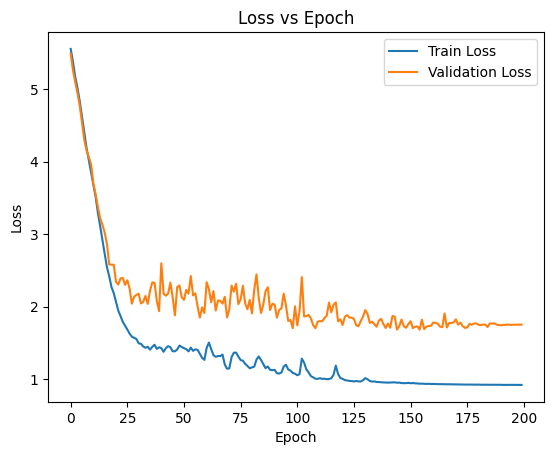

In [32]:
# Loss Visualization over Epochs
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epoch')
plt.show()

Model Evaluation and Predction

In [33]:
test_loss, test_accuracy = evaluate(model, val_dataloader, in_channels, len(val_dataset), 32, criterion)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 1.7490423387951322
Test Accuracy: 0.800235017626322


In [34]:
train_loss, train_accuracy = evaluate(model, train_dataloader, in_channels, len(train_dataset), 32, criterion)
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_accuracy}")

Train Loss: 0.8856507275828082
Train Accuracy: 1.0


Saving the Model

In [35]:
import os

# Create the directory if it doesn't exist
save_directory = '/content/drive/MyDrive/Sign-Language-Translator/saved_models/'
os.makedirs(save_directory, exist_ok=True)

In [36]:
# Save the model states with .pth extension
model_path = os.path.join(save_directory, 'word_level_model_states_include_v15.pth')
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/Sign-Language-Translator/saved_models/word_level_model_states_include_v15.pth


Hyperparameter Tuning using Optuna

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 12.6 MB/s eta 0:00:00


In [ ]:
import optuna

In [ ]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())

[I 2025-11-03 07:20:47,958] A new study created in memory with name: no-name-c3b10019-d60b-4318-a9f0-aa76d59b2646


In [ ]:
study = torch.load(os.path.join(save_directory, 'model_states_include_study.pth'), weights_only=False)

In [ ]:
# objective function
def objective(trail):
  # hyperparameter vaue from search space
  frame_hidden_layers = trail.suggest_int('frame_hidden_layers', 0, 3) # Reduced max layers
  frame_fc_dropout = trail.suggest_float('frame_fc_dropout', 0.0, 0.5, step=0.05)
  frame_dim = trail.suggest_int('frame_dim', 32, 512, step=32) # Frame encoder output dim

  num_temporal_layers = trail.suggest_int('num_temporal_layers', 1, 3) # Reduced max layers
  numHeads = trail.suggest_int('num_heads', 1, 16) # Transformer nHeads
  temporal_size = trail.suggest_int('temporal_size', 64, 1024, step=64) # Reduced max size
  temporal_dropout = trail.suggest_float('temporal_dropout', 0.0, 0.5, step=0.05)

  frame_dim -= frame_dim % numHeads # correct in_frame dim for Transformer with given num heads

  class_hidden_layers = trail.suggest_int('class_hidden_layers', 0, 2) # Reduced max layers

  learning_rate = trail.suggest_float('learning_rate', 4*1e-4, 7*1e-4, log=True) # Increased max learning rate
  # max_lr = trail.suggest_float('max_lr', 1e-3, 1e-2, log=True)

  weight_decay = trail.suggest_float('weight_decay', 3*1e-4, 7*1e-4, log=True) # Reduced min weight decay
  # batch_size = trail.suggest_categorical('batch_size', [32, 64]) # Reduced batch size options
  optimizer_name = trail.suggest_categorical('optimizer', ['Adam', 'AdamW'])

  # optimizer_name = 'Adam'
  batch_size = 32
  rnn_type = 'TRANSFORMER'
  epochs = 100 # Reduced epochs for faster trials
  num_nodes = 67 # Use the already defined num_nodes
  in_channels = 3

  frame_proj_neurons, proj_dropout_rates = [], []
  for i in range(frame_hidden_layers):
    frame_proj_neurons.append(trail.suggest_int(f'frame_proj_neurons_{i}', 64, 1024, step=64)) # Reduced max neurons
    proj_dropout_rates.append(trail.suggest_float(f'proj_dropout_rate_{i}', 0.0, 0.5, step=0.05)) # Reduced max dropout

  class_hidden_neurons, class_dropout_rates = [], []
  for i in range(class_hidden_layers):
    class_hidden_neurons.append(trail.suggest_int(f'class_hidden_neurons_{i}', 128, 4096, step=128)) # Reduced max neurons
    class_dropout_rates.append(trail.suggest_float(f'class_dropout_rate_{i}', 0.0, 0.5, step=0.05)) # Reduced max dropout

  # model initialize
  in_frame_size = num_nodes * in_channels
  output_size = num_classes # Use the already defined num_classes

  model = MyModel(in_frame_size, frame_proj_neurons, proj_dropout_rates, frame_fc_dropout,
                 frame_dim, temporal_size, num_temporal_layers, numHeads, temporal_dropout,
                 class_hidden_neurons, class_dropout_rates, output_size, rnn_type=rnn_type)
  model.to(device)

  # params initialize
  criterion = nn.CrossEntropyLoss()

  # create data loader
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=video_collate_fn)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=video_collate_fn)

  steps_per_epoch = len(train_loader)

  # select optimizer
  if optimizer_name == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_name == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
      raise ValueError("Unsupported optimizer")

  # select scheduler
  scheduler = OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=steps_per_epoch, epochs=epochs)

  # training loop
  for epoch in range(epochs):
    for x_batch, y_batch in train_loader:
      x_batch, y_batch = x_batch[:, :, :, :in_channels].to(device), y_batch.to(device)
      y_pred = model(x_batch)

      loss = criterion(y_pred, y_batch)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      scheduler.step() # Step the scheduler after each batch


  # evauation
  model.eval()
  _, accuracy = evaluate(model, val_loader, in_channels, len(val_dataset), batch_size, criterion)

  # return accuracy
  return accuracy

In [ ]:
study.optimize(objective, n_trials=100)

In [ ]:
torch.save(study, os.path.join(save_directory, 'model_states_include_study.pth'))

In [ ]:
study.best_params

{'frame_fc_dropout': 0.25,
 'frame_dim': 416,
 'temporal_size': 192,
 'temporal_dropout': 0.2,
 'learning_rate': 0.0005363515811751811,
 'weight_decay': 0.0005186214599734129,
 'batch_size': 32,
 'optimizer': 'Adam',
 'class_hidden_neurons_0': 1024,
 'class_dropout_rate_0': 0.0,
 'class_hidden_neurons_1': 640,
 'class_dropout_rate_1': 0.4}

In [ ]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_contour

In [ ]:
plot_optimization_history(study)

In [ ]:
plot_param_importances(study)

In [ ]:
plot_parallel_coordinate(study, params=list(study.best_params.keys()))

Load and Predict Model

In [37]:
import time

In [50]:
save_directory = '/content/drive/MyDrive/Sign-Language-Translator/saved_models'
model_path = os.path.join(save_directory, 'word_level_model_states_include_v15.pth')

model = MyModel(num_nodes*in_channels, [], [], 0.0, 480, 1024, 3, 8, 0.0,
                [1024], [0.5], output_size, rnn_type="TRANSFORMER")
model.to(device)

model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

MyModel(
  (frame_encoder): FrameEncoder(
    (node_proj): Sequential()
    (frame_fc): Sequential(
      (0): Linear(in_features=201, out_features=480, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
  )
  (sequence_classifier): SequenceClassifier(
    (rnn): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=480, out_features=480, bias=True)
          )
          (linear1): Linear(in_features=480, out_features=2048, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=2048, out_features=480, bias=True)
          (norm1): LayerNorm((480,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((480,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.0, inplace=False)
          (dropout2): Dropout(p=0.0, inplace=False)
        )
 

In [ ]:
def predict_gloss(model, x):
  x = x.unsqueeze(0).to(device)

  with torch.no_grad():
    out = model(x)
    out = nn.functional.softmax(out, dim=1)

  val, ypred = torch.max(out, 1)
  return ypred

In [54]:
# measuring time
start = time.time()

ypred = predict_gloss(model, val_dataset[200][0][:, :num_nodes, :in_channels])
print("Predicted Gloss:", label_to_class[ypred.item()])
print("Actual Gloss:", label_to_class[val_dataset[200][1]])

print(f"Time taken: {time.time() - start}")

Predicted Gloss: God
Actual Gloss: God
Time taken: 0.012768983840942383
